In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer 

import os

from IPython.display import HTML, display

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import PIL
from PIL import Image

import torch
import torch.utils.data as data_utils
import torchvision.models as models
from torch.nn.modules import CrossEntropyLoss, L1Loss
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn

import time

#### Declaration of constants to be used in the notebook

In [2]:
DATA_PATH = 'datasets/'

SAMPLE_MOVIE_POSTERS_PATH = DATA_PATH + 'posters/'
MOVIE_GENRE_FILE = DATA_PATH + 'MovieGenre.csv'

SAMPLE_DATASET_SIZE = 900

TRAINING_SET_PROPORTION = 0.70

BATCH_SIZE = 25
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
USE_GPU = False

### Dataset Inspection

#### 1. Movie Genres

Read the Movie Genre file

In [3]:
data = []

with open(MOVIE_GENRE_FILE, 'r', encoding='latin1') as f:
    csv_reader = csv.reader(f)

    for row in csv_reader:
        data.append(row)

Print the first few entries to inspect the structure of data

In [ ]:
data[0:5]

Create a dataframe from the data, using the entries at the first index as the column headers

In [5]:
columns = data.pop(0)

columns = list(map(lambda x: x.lower().replace(' ', '_'), columns))
movie_genre_df = pd.DataFrame(data, columns=columns)

Inspect the dataframe

In [6]:
movie_genre_df.shape

(40108, 6)

Drop duplicates from the dataframe and inspect again

In [7]:
movie_genre_df.drop_duplicates(inplace=True)

In [8]:
movie_genre_df.shape

(39515, 6)

In [ ]:
movie_genre_df.head()

Process the dataframe so that genres can be accessed easily further on 

In [10]:
# Split genre to create a list of values 
movie_genre_df['genre'] = movie_genre_df['genre'].apply(lambda x: x.split('|'))

# Expand genre into its own dataframe
tags = movie_genre_df['genre'].apply(pd.Series).fillna('')

# Rename the columns
tags = tags.rename(columns = lambda x : 'genre_' + str(x))

# Merge the genre dataframe back into the original dataframe
movie_genre_df = pd.concat([movie_genre_df[:], tags[:]], axis=1)

Inspect the dataframe

In [11]:
movie_genre_df.shape

(39515, 9)

In [12]:
movie_genre_df.head()

,imdbid,imdb_link,title,imdb_score,genre,poster,genre_0,genre_1,genre_2
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...,Animation,Adventure,Comedy
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...,Action,Adventure,Family
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Romance,
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Drama,Romance
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,"[Comedy, Family, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Family,Romance


Retrieve the distribution of unique genres across all movies

In [13]:
# Get distribution of unique values from multiple genre columns
# Remove the entry representing no genre
# Get combined counts of unique genres

genre_distribution = movie_genre_df[['genre_0', 'genre_1', 'genre_2']] \
            .apply(lambda s: s.value_counts()) \
            .drop('') \
            .sum(axis=1) \
            .reset_index()
                
# Rename the columns acordingly                
genre_distribution.columns = ['genre', 'count']

# Sort the dataframe to order by predominant genres 
genre_distribution = genre_distribution.sort_values(by='count', ascending=False).reset_index(drop=True)

# Store the unique genres as a dictionary
unique_genres = genre_distribution['genre'].tolist()
unique_genres = {x: i for (i,x) in enumerate(unique_genres)}
# unique_genres[''] = len(unique_genres)

Visualise the distribution of genres across movies

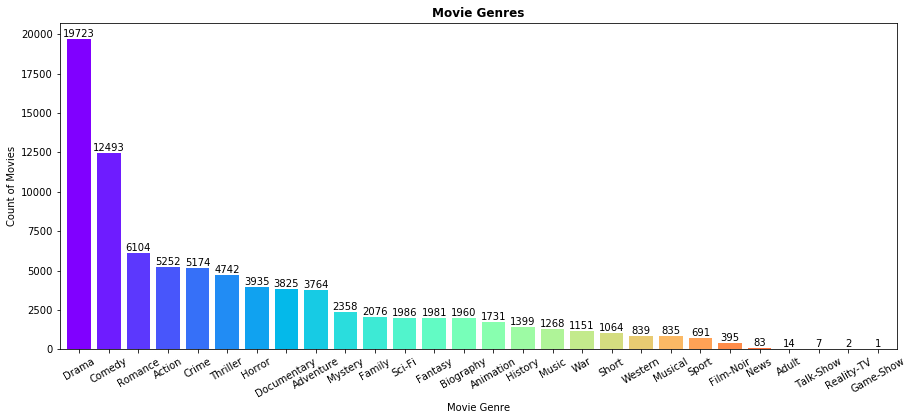

In [14]:
genres_count = genre_distribution.shape[0]
colors = cm.rainbow(np.linspace(0, 1, genres_count))


plot = genre_distribution.plot(x='genre', y='count', kind='bar', width=0.8, rot=0, figsize=(15,6), 
                               color=colors, legend=None)

plot.set_title('Movie Genres', fontweight='bold')

plot.set_ylabel('Count of Movies')
plot.set_xlabel('Movie Genre')

plot.set_xticklabels(labels=genre_distribution['genre'], rotation=30)

rects = plot.patches

# Now make some labels
labels = [int(genre_distribution['count'][i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    plot.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plot.get_figure() #.save_fig('')

#### 2. Sample Movie Posters

Create a list of the sample movie posters names by traversing the directory

In [15]:
poster_files = os.listdir(SAMPLE_MOVIE_POSTERS_PATH)

imdb_ids = [i.split('.')[0] for i in poster_files]
sample_movie_posters = [SAMPLE_MOVIE_POSTERS_PATH + i for i in poster_files]

print("Number of sample movie posters =", len(sample_movie_posters))

Number of sample movie posters = 997


Create a mini-batch of posters and associated genres.

In [16]:
mini_batch_posters = sample_movie_posters[0:SAMPLE_DATASET_SIZE]
mini_batch_imdb_ids = imdb_ids[0:SAMPLE_DATASET_SIZE]

mini_batch_genres = movie_genre_df[movie_genre_df['imdbid'].isin(mini_batch_imdb_ids)]['genre'].tolist()

num_classes = len(unique_genres)

Visualise the sample movie posters

In [34]:
markup = '<table>'

for i, poster in enumerate(mini_batch_posters[0:24]):
    if i%12 == 0:
        markup += '</tr/><tr>'

    markup += '<td><img src=' + poster +' width="70" height="70"/><span>' + ',\n'.join(mini_batch_genres[i]) + '</span</td>'
    
markup += '</table>'

display(HTML(markup))

"Drama, Romance</span","Comedy, Romance</span","Comedy, Musical, Romance</span",Drama</span,"Drama, Romance</span","Drama, Romance, War</span","Comedy, Musical, War</span","Crime, Drama, Mystery</span","Fantasy, Horror</span","Drama, Romance, War</span","Drama, Musical, Romance</span","Drama, War</span"
"Drama, Western</span","Drama, Romance</span","Drama, Romance, War</span","Drama, Sci-Fi</span","Animation, Family, Comedy</span","Crime, Mystery, Thriller</span","Biography, Music, Romance</span","Crime, Mystery, Thriller</span","Comedy, Romance, Thriller</span",Drama</span,"Comedy, Musical</span","Comedy, Drama</span"


Inspect the dimensions of one of the posters

In [18]:
sample_poster = np.array(PIL.Image.open(mini_batch_posters[0]))
print("Poster dimensions :", sample_poster.shape)

Poster dimensions : (268, 182, 3)


Resize the posters as square images are nice to work with and also convert them into numpy arrays

In [19]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

preprocessFn = transforms.Compose([
        transforms.RandomSizedCrop(16)
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         normalize
])

### Model preparation

#### 1. Partition the data into training and test sets

In [20]:
train_size = int(len(mini_batch_posters)*TRAINING_SET_PROPORTION)

train_posters = mini_batch_posters[:train_size]
test_posters = mini_batch_posters[train_size:]

multi_label_binarizer = MultiLabelBinarizer(list(unique_genres.keys()))
y = multi_label_binarizer.fit_transform(mini_batch_genres)
y_train = torch.from_numpy(y[:train_size])
y_test = torch.from_numpy(y[train_size:])

# X_train_temp = [preprocessFn(PIL.Image.open(i)).unsqueeze(0) for i in train_posters]
X_train_temp = [torch.from_numpy(np.transpose(np.array(preprocessFn(PIL.Image.open(i))).T, (0,2,1))).float().unsqueeze(0) for i in train_posters]

for i, x in enumerate(X_train_temp):
    if i == 0:
        X_train = x
    else:
        X_train = torch.cat((X_train, x), 0)
    
# X_test_temp = [preprocessFn(PIL.Image.open(i)).unsqueeze(0) for i in test_posters]
X_test_temp = [torch.from_numpy(np.transpose(np.array(preprocessFn(PIL.Image.open(i))).T, (0,2,1))).float().unsqueeze(0) for i in test_posters]

for i, x in enumerate(X_test_temp):
    if i == 0:
        X_test = x
    else:
        X_test = torch.cat((X_test, x), 0)

print("X_train shape: ", X_train.size())
print("y_train shape: ", y_train.size())
print("X_test shape: ", X_test.size())
print("y_test shape: ", y_test.size())

X_train shape:  torch.Size([630, 3, 16, 16])
y_train shape:  torch.Size([630, 28])
X_test shape:  torch.Size([270, 3, 16, 16])
y_test shape:  torch.Size([270, 28])


Create Tensor objects for the training and test sets

In [21]:
train = data_utils.TensorDataset(X_train, y_train)

# Use weight-sampling to account for class-imbalance
class_sample_count = [int(genre_distribution[genre_distribution['genre'] == x]['count'].values[0]) \
                          for x in multi_label_binarizer.classes]
weights = (1 / torch.Tensor(class_sample_count)).double()
sampler = data_utils.sampler.WeightedRandomSampler(weights, BATCH_SIZE)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, sampler = sampler)

test = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

dataset_sizes = {'train': len(train), 'val': 0}

Download a pretrained model and adapt it

In [ ]:
# Download a pretrained AlexNet model
# alexnet = models.alexnet(pretrained=True)
# vggnet = models.vgg16(pretrained=True)
resnet = models.resnet152(pretrained=True)
model = resnet
print('ResNet Model', model)

for param in model.parameters():
    param.requires_grad = False

# Remove last layer
# new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
# model.classifier = new_classifier

# Add custom layer to predict num_classes
# model.classifier._modules['7'] = nn.ReLU(inplace=True)
# model.classifier._modules['8'] = nn.Dropout(p = 0.5)
# model.classifier._modules['9'] = nn.Linear(1000, num_classes)
# model.classifier._modules['10'] = nn.Softmax()

# print('Custom Model', model)

# model.use_memory = False

In [23]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
# model.add_module('fc_custom', nn.Linear(model.fc.out_features, num_classes))
# model.add_module('softmax', nn.Softmax())

# criterion = nn.CrossEntropyLoss()
criterion = nn.MultiLabelSoftMarginLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=0.9)
# optimizer = optim.Adam(model.fc.parameters())

phase = 'train'

Define the parameters required for training the model

In [24]:
class CustomNet(nn.Module):
    def __init__(self, model):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(CustomNet, self).__init__()
        self.model = model

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        x = self.model(x)
        x = nn.functional.softmax(x)
        return x

In [25]:
def train_model(model):
    since = time.time()
    loss_history = []
    
    model.train(True)  # Set model to training mode

    for epoch in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(epoch, NUM_EPOCHS - 1))
        print('-' * 10)

        running_loss = []

        # Iterate over data.
        for batch_idx, (inputs, targets) in enumerate(train_loader):

            inputs = Variable(inputs)
            targets = Variable(targets).float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
#             if epoch == NUM_EPOCHS - 2:
#             print('targets:', targets.data, 'outputs:', outputs.data)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss.append(loss.data[0])

        epoch_loss = np.mean(running_loss)
        loss_history.append(epoch_loss)

        print('{} loss: {:.4f}'.format(phase, epoch_loss))
        print('*' * 100)
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return loss_history, targets.data, outputs.data

In [26]:
def test_model(model):
    since = time.time()
    loss_history = []
    total_num_labels = 0
    preds_correct = 0
    
    model.train(False)  # Set model to training mode

    running_loss = []

    # Iterate over data.
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        inputs = Variable(inputs)
        targets = Variable(targets).float()

        # forward
        outputs = model(inputs)
        
        for i, t in enumerate(targets.data):
            labels = t.nonzero()[:,0].tolist()
            num_labels = len(labels)
            j, preds = outputs.data[i].topk(num_labels)
            preds = [p for k, p in enumerate(preds) if j[k] != 0]
            preds_correct += len(set(preds).intersection(labels))
            total_num_labels += num_labels

    accuracy = preds_correct / total_num_labels
    print('Accuracy: ', accuracy)
    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return accuracy, targets.data, outputs.data

Create a model with custom network architecture

In [ ]:
custom_model = CustomNet(model)
print('Custom Model', custom_model)

optimizer = optim.Adam(custom_model.model.fc.parameters(), lr=LEARNING_RATE, weight_decay=0.1)

Train the model

In [28]:
loss_history, targets, outputs = train_model(custom_model)

Epoch 0/49
----------
train loss: 0.7080
****************************************************************************************************
Epoch 1/49
----------
train loss: 0.7075
****************************************************************************************************
Epoch 2/49
----------
train loss: 0.7074
****************************************************************************************************
Epoch 3/49
----------
train loss: 0.7071
****************************************************************************************************
Epoch 4/49
----------
train loss: 0.7071
****************************************************************************************************
Epoch 5/49
----------
train loss: 0.7066
****************************************************************************************************
Epoch 6/49
----------
train loss: 0.7063
****************************************************************************************************
Epoch 

Visualise the training loss over epochs

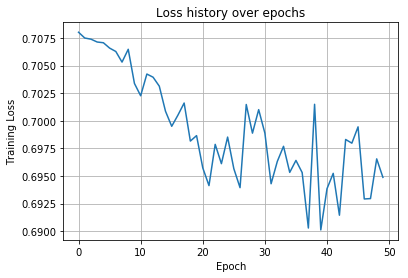

In [33]:
plt.gcf().clear()
plt.plot(np.arange(0, NUM_EPOCHS), loss_history)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss history over epochs')
plt.grid(True)
plt.show()

Use the model to get predictions on the test set

In [30]:
accuracy, targets, outputs = test_model(custom_model)

Accuracy:  0.29313543599257885
Testing complete in 0m 5s


In [31]:
targets



Columns 0 to 12 
    0     0     0     0     1     1     0     0     0     0     0     0     0
    0     1     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     1     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0    

In [32]:
outputs



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.000